In [1]:
import os
import sys
import shutil
import numpy as np
import numba
from numba import cuda  #cuda不合适整合在class里？
import random
from tqdm import trange
import math
import time

import matplotlib.pylab as plt
import matplotlib.animation as animation
from IPython import display

os.environ['CUDA_VISIBLE_DEVICES'] = "0" 

In [2]:
def mkdir(path):
    isexist = os.path.exists(path)
    if isexist == True : 
        shutil.rmtree(path)
        os.makedirs(path)
        return True
    else:
        os.makedirs(path)
        return False

In [3]:
#params
n_atom = 100
n_step = 1000
step_h = 0.01 #时间步长
hover2 = step_h/2.0
T_init = 0.5
eps = 1.0
r2cutoff = 9
L = int(1.0*n_atom**0.5)

threads_per_block = 32
blocks_per_grid = math.ceil(n_atom / threads_per_block)

In [4]:
#initialize vars
cur_posi = np.zeros((n_atom,2), dtype=np.float64)
cur_v = np.zeros((n_atom,2), dtype=np.float64)
#cur_f = np.zeros((n_atom,2), dtype=np.float64)
#next_f = np.zeros((n_atom,2), dtype=np.float64)
timer = np.arange(n_step, dtype=np.int64)
traj = np.zeros((n_atom,n_step+1,2), dtype=np.float64)
EP_traj = np.zeros(n_step, dtype=np.float64)
EK_traj = np.zeros(n_step, dtype=np.float64)
ET_traj = np.zeros(n_step, dtype=np.float64)
        
#initialize position,velocity
x_grid = np.linspace(0,L-1,int(L))
y_grid = np.linspace(0,L-1,int(L))
x_noise = np.random.rand(1,L)[0]/100
y_noise = np.random.rand(1,L)[0]/100
i = 0
for ix in range(len(x_grid)):
    for iy in range(len(y_grid)):
        x = x_grid[ix] + x_noise[ix]
        y = y_grid[iy] + y_noise[iy]
        cur_posi[i] = [x,y]
        i += 1
for row in range(cur_v.shape[0]):
    cur_v[row,0] = random.gauss(0,1) * np.sqrt(T_init)
    cur_v[row,1] = random.gauss(0,1) * np.sqrt(T_init)

In [5]:
@cuda.jit
def calcu_single_forceEP(f_array_dev, EP_dev, cur_posi_dev):
    '''
    get force and EP for a single atom
    '''
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if idx < n_atom:
        atom_1 = idx
        
        for atom_2 in range(0, n_atom):
            if atom_2 == atom_1:
                continue
            dx = cur_posi_dev[atom_1][0] - cur_posi_dev[atom_2][0]
            dy = cur_posi_dev[atom_1][1] - cur_posi_dev[atom_2][1]
            if dx > 0.5*L:
                dx = dx - L
            if dx < -0.5*L:
                dx = dx + L
            if dy > 0.5*L:
                dy = dy - L
            if dy < -0.5*L:
                dy = dy + L

            r2 = dx*dx + dy*dy
            if r2 < r2cutoff:
                invr2 = 1.0/r2
                invr6 = invr2**3
                w = 48*eps*invr2*invr6*(invr6-0.5)
                fx = w*dx
                fy = w*dy
                EP = 4.0*eps*(invr6)*(invr6-1)
                
                f_array_dev[atom_1][0] = f_array_dev[atom_1][0] + fx
                f_array_dev[atom_1][1] = f_array_dev[atom_1][1] + fy
                EP_dev[atom_1] = EP + EP_dev[atom_1]

def calcu_forceEP(cur_posi):
    '''
    get forces and EP from position
    '''
    EP_array = np.zeros(n_atom)
    f_array = np.zeros((n_atom,2))
    EP_dev = cuda.to_device(EP_array)
    f_array_dev = cuda.to_device(f_array)
    cur_posi_dev = cuda.to_device(cur_posi)
    calcu_single_forceEP[blocks_per_grid, threads_per_block](f_array_dev, EP_dev, cur_posi_dev)
    f_array = f_array_dev.copy_to_host()
    EP_array = EP_dev.copy_to_host()
    return f_array, np.sum(EP_array)/2

@cuda.jit
def calcu_single_nextposi(cur_posi_dev, cur_v_dev, cur_f_dev):
    '''
    map a single atom to next position
    '''
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if idx < n_atom:
        new_posi_x = cur_posi_dev[idx][0] + step_h*(cur_v_dev[idx][0] + hover2*cur_f_dev[idx][0])
        new_posi_y = cur_posi_dev[idx][1] + step_h*(cur_v_dev[idx][1] + hover2*cur_f_dev[idx][1])
                                                    
        if new_posi_x < 0:
            new_posi_x = new_posi_x + L
        if new_posi_x > L:
            new_posi_x = new_posi_x - L
        if new_posi_y < 0:
            new_posi_y = new_posi_y + L
        if new_posi_y > L:
            new_posi_y = new_posi_y - L
        
        cur_posi_dev[idx][0] = new_posi_x
        cur_posi_dev[idx][1] = new_posi_y

def update_posi(cur_posi, cur_v, F_t1):
    '''
    map all atoms to next position
    '''
    cur_posi_dev = cuda.to_device(cur_posi)
    cur_v_dev = cuda.to_device(cur_v)
    F_t1_dev = cuda.to_device(F_t1)
    calcu_single_nextposi[blocks_per_grid, threads_per_block](cur_posi_dev, cur_v_dev, F_t1_dev)
    cur_posi = cur_posi_dev.copy_to_host()
    return cur_posi

@cuda.jit
def calcu_single_EK(cur_v_dev, EK_dev):
    '''
    get EK of each atom
    '''
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if idx < n_atom:
        EK = (cur_v_dev[idx][0]*cur_v_dev[idx][0] + cur_v_dev[idx][1]*cur_v_dev[idx][1])/2
        EK_dev[idx] = EK

def calcu_EK(cur_v):
    '''
    get EK of all atoms
    '''
    EK_array = np.zeros(n_atom)
    EK_dev = cuda.to_device(EK_array)
    cur_v_dev = cuda.to_device(cur_v)
    calcu_single_EK[blocks_per_grid, threads_per_block](cur_v_dev, EK_dev)
    EK_array = EK_dev.copy_to_host()
    return np.sum(EK_array)

@cuda.jit
def calcu_single_vel(cur_v_dev, F_t1_dev, F_t2_dev):
    '''
    update vel of one atom
    '''
    idx = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    if idx < n_atom:
        new_v_x = cur_v_dev[idx][0] + hover2*(F_t1_dev[idx][0] + F_t2_dev[idx][0])
        new_v_y = cur_v_dev[idx][1] + hover2*(F_t1_dev[idx][1] + F_t2_dev[idx][1])
        cur_v_dev[idx][0] = new_v_x
        cur_v_dev[idx][1] = new_v_y
    
def update_vel(cur_v, F_t1, F_t2):
    '''
    update vel of all atoms
    '''
    cur_v_dev = cuda.to_device(cur_v)
    F_t1_dev = cuda.to_device(F_t1)
    F_t2_dev = cuda.to_device(F_t2)
    calcu_single_vel[blocks_per_grid, threads_per_block](cur_v_dev, F_t1_dev, F_t2_dev)
    cur_v = cur_v_dev.copy_to_host()
    return cur_v

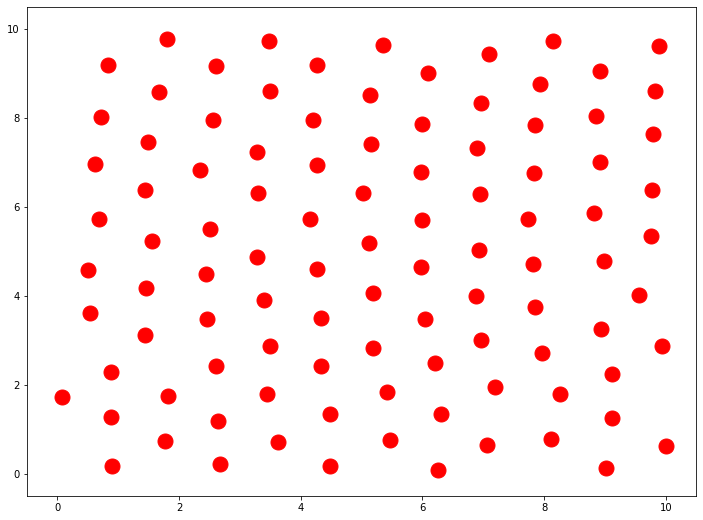

100%|██████████| 1000/1000 [00:12<00:00, 78.48it/s]

time: 12.74s


In [8]:
start = time.time()
for it in trange(n_step):
    #F and EK need to be calculated in first iter once, and the first position
    if it == 0:
        F_t1,EP_t1 = calcu_forceEP(cur_posi)
        traj[:,it,:] = cur_posi
    
    #save traj, update position to t2, get new F,EP,EK
    cur_posi = update_posi(cur_posi, cur_v, F_t1)
    cuda.synchronize() #wait variable update
    F_t2,EP_t2 = calcu_forceEP(cur_posi)
    EK_t1 = calcu_EK(cur_v)
    
    #update vel to t2
    cur_v = update_vel(cur_v, F_t1, F_t2)
    cuda.synchronize() #wait variable update
    
    #save traj,E_traj, in next iter, F_t1=F_t2, EP_t1=EP_t2
    traj[:,it+1,:] = cur_posi
    EP_traj[it] = EP_t1
    EK_traj[it] = EK_t1
    ET_traj[it] = EP_t1 + EK_t1
    F_t1 = F_t2
    EP_t1 = EP_t2
    
    #'''
    if it%10==0:
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(12,9))
        plt.xlim(-0.5, L+0.5)
        plt.ylim(-0.5, L+0.5)
        plt.plot(cur_posi[:,0],cur_posi[:,1], 'ro', markersize=15)
        plt.show()
    #'''
        
print('time: {:.2f}s'.format(time.time()-start))

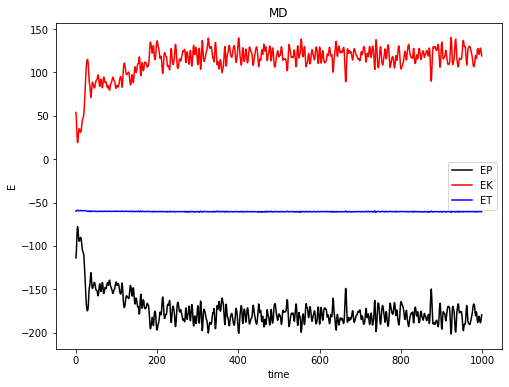

In [7]:
fig = plt.figure(figsize=(8,6))
plt.plot(timer, EP_traj, 'k-', label='EP')
plt.plot(timer, EK_traj, 'r-', label='EK')
plt.plot(timer, ET_traj, 'b-', label='ET')
plt.xlabel('time')
plt.ylabel('E')
plt.title('MD')
plt.legend()
plt.show()